In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# let's start with the super useful intro on how to extract a BED file with gene annotation from HiGlass docs ...
# https://docs.higlass.io/data_preparation.html#gene-annotation-tracks

In [5]:
ASSEMBLY="hg19"
TAXID=9606
DATADIR="./gene_annot_data"


### let's download some refseq, gene info and stuff

In [6]:
# %%bash
# DATADIR=./gene_annot_data
# mkdir -p $DATADIR
# mkdir -p $DATADIR/genbank
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2refseq.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene_info.gz
# wget -N -P $DATADIR ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2pubmed.gz


## Download data from UCSC and NCBI

In [446]:
%%bash -s "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# # Download UCSC refGene database for assembly of interest
# mkdir $DATADIR/$ASSEMBLY
# # wget -N -P $DATADIR/$ASSEMBLY/ http://hgdownload.cse.ucsc.edu/goldenPath/$ASSEMBLY/database/refGene.txt.gz

# # Filter genbank data for species of interest
# zcat $DATADIR/gene2refseq.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2refseq
zcat $DATADIR/gene_info.gz | grep ^${TAXID} | sort -k 2b,2 > $DATADIR/$ASSEMBLY/gene_info # gene-centric
# zcat $DATADIR/gene2pubmed.gz | grep ^${TAXID} > $DATADIR/$ASSEMBLY/gene2pubmed

# Sort
# Optional: filter out unplaced and unlocalized scaffolds (which have a "_" in the chrom name)
zcat $DATADIR/$ASSEMBLY/refGene.txt.gz \
    | awk -F $'\t' '{if (!($3 ~ /_/)) print;}' \
    | sort -k 2b,2 \
    > $DATADIR/$ASSEMBLY/refGene_sorted

# read about the compatibility of sort and join here:
# https://www.gnu.org/software/coreutils/manual/html_node/Sorting-files-for-join.html
# to join reliably and without warnings, input files have to sorted a certain way

## Get full model and citation count for each gene

In [455]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Count pubmed citations
# Output: {gene_id} \t {citation_count}
cat $DATADIR/$ASSEMBLY/gene2pubmed \
    | awk '{print $2}' \
    | sort \
    | uniq -c \
    | awk '{print $2 "\t" $1}' \
    | sort -k1b,1 \
    > $DATADIR/$ASSEMBLY/gene2pubmed-count

# Gene2refseq dictionary
# Output: {gene_id} \t {refseq_id}
cat $DATADIR/$ASSEMBLY/gene2refseq \
    | awk -F $'\t' '{ split($4,a,"."); if (a[1] != "-") print $2 "\t" a[1];}' \
    | sort -k1b,1 \
    | uniq  \
    > $DATADIR/$ASSEMBLY/geneid_refseqid

echo "uniq RefSeq entries in geneid_refseqid ..."
cut -f2 $DATADIR/$ASSEMBLY/geneid_refseqid |sort|uniq|wc -l
echo "uniq gene_id entries in geneid_refseqid ..."
cut -f1 $DATADIR/$ASSEMBLY/geneid_refseqid |sort|uniq|wc -l

# Append refseq IDs to citation count table
# Output: {gene_id} \t {refseq_id} \t {citation_count}
join -a 1 -e "0" -o 1.1 1.2 2.1 -t $'\t' \
    $DATADIR/$ASSEMBLY/geneid_refseqid \
    $DATADIR/$ASSEMBLY/gene2pubmed-count  \
    | sort -k2b,2 \
    > $DATADIR/$ASSEMBLY/geneid_refseqid_count

echo "uniq gene_id entries in geneid_refseqid_count ..."
cut -f1 $DATADIR/$ASSEMBLY/geneid_refseqid_count |sort|uniq|wc -l

# Join the refseq gene model against gene IDs
# Output: {gene_id} \t {refseq_id} \t {chrom}(5) \t {strand}(6) \t {txStart}(7) \t {txEnd}(8) \t {cdsStart}(9) \t {cdsEnd}(10) \t {exonCount}(11) \t {exonStarts}(12) \t {exonEnds}(13)
join -1 2 -2 2 \
    $DATADIR/$ASSEMBLY/geneid_refseqid_count \
    $DATADIR/$ASSEMBLY/refGene_sorted \
    | awk '{ print $2 "\t" $1 "\t" $5 "\t" $6 "\t" $7 "\t" $8 "\t" $9 "\t" $10 "\t" $11 "\t" $12 "\t" $13 "\t" $3; }' \
    | sort -k1b,1   \
    > $DATADIR/$ASSEMBLY/geneid_refGene_count
    
echo "uniq gene_id entries in geneid_refGene_count ..."
cut -f1 $DATADIR/$ASSEMBLY/geneid_refGene_count |sort|uniq|wc -l

# Join citation counts against gene information
# make sure we keep genes that have no citation info !, hence "-a 1 -e "0"" options:
# output -> geneid \t symbol \t gene_type \t gene_descr \t citation_count
join -1 2 -2 1 -a 1 -e "0" -o 1.2 1.3 1.10 1.12 2.2 -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_info \
    $DATADIR/$ASSEMBLY/gene2pubmed-count \
    | sort -k1b,1 \
    > $DATADIR/$ASSEMBLY/gene_subinfo_citation_count

uniq RefSeq entries in geneid_refseqid ...
168138
uniq gene_id entries in geneid_refseqid ...
38723
uniq gene_id entries in geneid_refseqid_count ...
38723
uniq gene_id entries in geneid_refGene_count ...
28228


In [464]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# Output: {gene_id} \t {refseq_id} \t {chrom}(5) \t {strand}(6) \t {txStart}(7) \t {txEnd}(8) \t {cdsStart}(9) \t {cdsEnd}(10) \t {exonCount}(11) \t {exonStarts}(12) \t {exonEnds}(13)
head $DATADIR/$ASSEMBLY/geneid_refGene_count

1	NM_130786	chr19	-	58856548	58864858	58858387	58864803	8	58856548,58858718,58861735,58862756,58863648,58864293,58864657,58864769,	58858395,58859006,58862017,58863053,58863921,58864563,58864693,58864858,	1
10	NM_000015	chr8	+	18248791	18258725	18257513	18258386	2	18248791,18257507,	18248855,18258725,	10
100	NM_000022	chr20	-	43248162	43280340	43248474	43280248	12	43248162,43248939,43249658,43251228,43251469,43251647,43252842,43254209,43255096,43257687,43264867,43280215,	43248488,43249042,43249788,43251293,43251571,43251719,43252970,43254325,43255240,43257810,43264929,43280340,	100
100	NM_001322050	chr20	-	43248159	43280399	43248474	43255169	11	43248159,43248939,43249658,43251228,43251469,43251647,43252842,43255096,43257687,43264867,43280215,	43248488,43249042,43249788,43251293,43251571,43251719,43252970,43255240,43257810,43264929,43280399,	100
100	NM_001322051	chr20	-	43248159	43280399	43248474	43280248	11	43248159,43248939,43249658,43251228,43251469,43252842,43254209,43255096,43257687

In [466]:
%%bash -s  "$ASSEMBLY" "$TAXID" "$DATADIR"
ASSEMBLY=$1
TAXID=$2
DATADIR=$3
# 1: chr (chr1)
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16] -> useless ...
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,52307342,52307757,52308222,52309008,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,52307554,52307857,52308369,52309284,52310017,52312899,52317145,)
#
# joining 2 files according to the specified output, based on their columns:
# gene_subinfo_citation_count -> geneid \t symbol \t gene_type \t gene_descr \t citation_count
# geneid_refGene_count -> {gene_id} \t {refseq_id} \t {chrom} \t {strand} \t {txStart} \t {txEnd} \t {cdsStart} \t {cdsEnd} \t {exonCount} \t {exonStarts} \t {exonEnds}
#
join -o 2.3 2.5 2.6 1.2 1.5 2.4 2.2 1.1 1.3 1.4 2.7 2.8 2.10 2.11 -t $'\t' \
    $DATADIR/$ASSEMBLY/gene_subinfo_citation_count \
    $DATADIR/$ASSEMBLY/geneid_refGene_count \
    > $DATADIR/$ASSEMBLY/geneAnnotations.bed

# Download: https://raw.githubusercontent.com/higlass/clodius/develop/scripts/exonU.py
# make sure to update/report an issue about "exonU.py" regarding the txStart and txEnd integer casting ...
# because in the current form it is sorting txStart/End lexicographically ...
# ! scp ghpcc:/nl/umw_job_dekker/cshare/reference/sorted_chromsizes/hg19.reduced.chrom.sizes ./
python exonU.py $DATADIR/$ASSEMBLY/geneAnnotations.bed > $DATADIR/$ASSEMBLY/geneAnnotationsExonUnions.bed

# Some of the gene_ids are duplicated in the final geneAnnotationsExonUnions.bed - those appear to be "real" duplicated genes
# mostly associated with unmappable areas etc - probably related to the Encode blacklisting - should check someday

### Further filter and preprare our RefSeq-based list of genes

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### some stats ...

<AxesSubplot:xlabel='geneType,strand'>

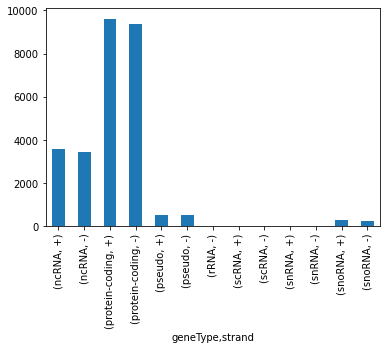

In [5]:
# by geneType and strand ...
genes_df.groupby(["geneType","strand"]).size().plot.bar()

### merging RNA-seq expression data with our gene annotation ...

In [83]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [84]:
yyy = pd.merge(
    rsem_df,
    genes_df,
    how = 'left',
    left_on="Id",
    right_on="geneName"
)

In [85]:
yyy[yyy.isna().any(axis=1)]

,Id,rsem.out.S442_IAA,rsem.out.S442_IAAR2,rsem.out.S442_NT,rsem.out.S442_NTR2,rsem.out.S442_siCTRL_IAAR2,rsem.out.S442_siCTRL_NTR2,rsem.out.S442_siCtrl_IAA,rsem.out.S442_siCtrl_NT,rsem.out.S442_siDDX55_IAA,...,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
14,GPR98,10,6,8,4,4,4,5,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,MIR941-2,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,BSN-AS2,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,LINC01279,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,LINC00864,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25787,TTTY17A,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25789,MIR515-1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25791,SELO,27,39,23,36,46,37,34,29,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25794,LOC653602,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

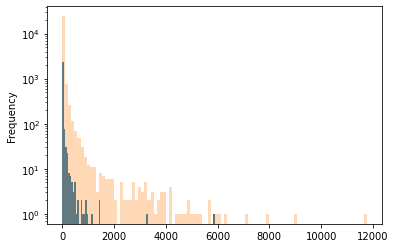

In [86]:
yyy[yyy.isna().any(axis=1)]["rsem.out.S442_NT"].plot.hist(log=True,bins=100)
yyy["rsem.out.S442_NT"].plot.hist(log=True,bins=100,alpha=0.3)

In [59]:
yyy[yyy.isna().any(axis=1)]["Id"]

14              GPR98
39           MIR941-2
41            BSN-AS2
46          LINC01279
47          LINC00864
             ...     
25787         TTTY17A
25789        MIR515-1
25791            SELO
25794       LOC653602
25799    LOC101927905
Name: Id, Length: 2582, dtype: object

In [78]:
yyy[yyy.isna().any(axis=1)]["Id"].reset_index(drop=True)

0              GPR98
1           MIR941-2
2            BSN-AS2
3          LINC01279
4          LINC00864
            ...     
2577         TTTY17A
2578        MIR515-1
2579            SELO
2580       LOC653602
2581    LOC101927905
Name: Id, Length: 2582, dtype: object

In [75]:
pd.merge(
    yyy[yyy.isna().any(axis=1)]["Id"].reset_index(drop=True),
    pd.read_csv("./gene_annot_data/hg19/refGene_sorted",sep="\t",header=None)[12],
    how="inner",
    left_on="Id",
    right_on=12
).drop_duplicates()
# pd.read_csv("./gene_annot_data/hg19/refGene_sorted",sep="\t",header=None)[12]

,Id,12
0,MIR941-2,MIR941-2
3,TTTY1B,TTTY1B
5,F8A1,F8A1
8,C9orf16,C9orf16
9,CXorf56,CXorf56
...,...,...
1848,CCDC58,CCDC58
1850,DAZ4,DAZ4
1856,TP53TG3B,TP53TG3B
1868,TTTY17A,TTTY17A


In [69]:
pd.merge(
    yyy[yyy.isna().any(axis=1)]["Id"].reset_index(drop=True),
    pd.read_csv("./gene_annot_data/hg19/gene_info",sep="\t",header=None)[2],
    how="inner",
    left_on="Id",
    right_on=2
)

,Id,2
0,MIR941-2,MIR941-2
1,TTTY1B,TTTY1B
2,F8A1,F8A1
3,MIR548AU,MIR548AU
4,HGH1,HGH1
...,...,...
389,RNU6-79P,RNU6-79P
390,DAZ4,DAZ4
391,TP53TG3B,TP53TG3B
392,TTTY17A,TTTY17A


In [44]:
refGene_sorted

NameError: name 'refGene_sorted' is not defined

In [6]:
genes_df

,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,1,chr19,58856548,58864858,A1BG,31,-,union_1,protein-coding,alpha-1-B glycoprotein,58858387,58864803,"58856548,58858718,58861735,58862756,58863648,5...","58858395,58859006,58862017,58863053,58863921,5..."
1,2,chr12,9220303,9268825,A2M,273,-,union_2,protein-coding,alpha-2-macroglobulin,9220418,9268445,"9220303,9220778,9221335,9222340,9223083,922495...","9220435,9220820,9221438,9222409,9223174,922508..."
2,3,chr12,9381128,9386803,A2MP1,6,-,union_3,pseudo,alpha-2-macroglobulin pseudogene 1,9386803,9386803,"9381128,9381967,9382848,9383605,9384201,938465...","9381294,9382009,9382951,9383674,9384292,938478..."
3,9,chr8,18027975,18081198,NAT1,245,+,union_9,protein-coding,N-acetyltransferase 1,18079556,18080429,"18027975,18028187,18067289,18067611,18067617,1...","18028016,18028248,18067464,18067689,18067689,1..."
4,10,chr8,18248791,18258725,NAT2,706,+,union_10,protein-coding,N-acetyltransferase 2,18257513,18258386,"18248791,18257507","18248855,18258725"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27516,116804915,chr6,166581584,166584660,LNCDAT,1,+,union_116804915,ncRNA,lncRNA divergent activator of TBXT,166584660,166584660,"166581584,166581764,166581764,166581852,166582...","166581638,166582086,166582191,166582086,166582..."
27517,116804918,chr11,120894810,121062199,TBCEL-TECTA,0,+,union_116804918,protein-coding,TBCEL-TECTA readthrough,120916399,121061515,"120894810,120916382,120918236,120924259,120925...","120895000,120916532,120918376,120924441,120926..."
27518,117779438,chr1,20480706,20487061,LOC117779438,0,+,union_117779438,ncRNA,-,20487061,20487061,"20480706,20480706,20486122","20481080,20487061,20487061"
27519,118142757,chr6,42123143,42147794,LOC118142757,24,+,union_118142757,protein-coding,-,42141351,42147141,"42123143,42130657,42130657,42141070,42146017,4...","42123331,42130833,42131204,42141552,42146167,4..."


### after "filtering" our list of genes we are left with ~ 27k of them, and let's get to extracting TSS/TTS and other useful info

In [558]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd"]

pgenes_df =  genes_df[ genes_df["strand"] == "+" ][tx_cols].reset_index(drop=True)
mgenes_df =  genes_df[ genes_df["strand"] == "-" ][tx_cols].reset_index(drop=True)

#### carefully extract TSS from the genes, considering their orientation, and possible duplications ...

In [559]:
pTSS = pgenes_df.copy()
mTSS = mgenes_df.copy()
# after copying, pTSS and mTSS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txStart, and modify txEnd to be ~several bp downstream:
pTSS["txEnd"] = pTSS["txStart"] + 1
pTSS["strand"] = "+"
# report how many TSS were duplicated here:
print(f" there are {pTSS.duplicated().sum()} duplicated pTSSs ...")
pTSS = pTSS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(pTSS)} +TSSs to work with...")

# for genes on m-strand, we keep txEnd, and modify txStart to be ~several bp downstream (relative to the gene):
mTSS["txStart"] = mTSS["txEnd"] - 1
mTSS["strand"] = "-"
# report how many TSS were duplicated here:
print(f" there are {mTSS.duplicated().sum()} duplicated mTSSs ...")
mTSS = mTSS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(mTSS)} -TSSs to work with...")

# after modifying pTSS and mTSS separately - let's bring them back together ...
TSS = pd.concat([pTSS,mTSS]).reset_index(drop=True)
print(f"there are still {TSS.duplicated(subset=tx_cols).sum()} duplicated TSSs ... drop em")
TSS = TSS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(TSS)} -TSSs to work with...")

# DROP IT !
TSS.to_csv("allTSS_wstrand.bed",index=False,header=None,sep="\t")

 there are 66 duplicated pTSSs ...
finally there are 13921 +TSSs to work with...
 there are 58 duplicated mTSSs ...
finally there are 13476 -TSSs to work with...
there are still 1 duplicated TSSs ... drop em
finally there are 27396 -TSSs to work with...


#### carefully extract TTS (aka 3' end of the gene ) from the list of genes, considering their orientation, and possible duplications ...

In [560]:
pTTS = pgenes_df.copy()
mTTS = mgenes_df.copy()
# after copying, pTTS and mTTS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txEnd, and modify txStart to be ~several bp upstream:
pTTS["txStart"] = pTTS["txEnd"] - 1
pTTS["strand"] = "+"
# report how many TTS were duplicated here:
print(f" there are {pTTS.duplicated().sum()} duplicated pTTSs ...")
pTTS = pTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(pTTS)} +TTSs to work with...")

# for genes on m-strand, we keep txStart, and modify txEnd to be ~several bp upstream (relative to the gene):
mTTS["txEnd"] = mTTS["txStart"] + 1
mTTS["strand"] = "-"
# report how many TTS were duplicated here:
print(f" there are {mTTS.duplicated().sum()} duplicated mTTSs ...")
mTTS = mTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(mTTS)} -TTSs to work with...")

# after modifying pTTS and mTTS separately - let's bring them back together ...
TTS = pd.concat([pTTS,mTTS]).reset_index(drop=True)
print(f"there are still {TTS.duplicated(subset=tx_cols).sum()} duplicated TTSs ... drop em")
TTS = TTS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(TTS)} -TTSs to work with...")

# DROP IT !
TTS.to_csv("allTTS_wstrand.bed",index=False,header=None,sep="\t")

 there are 120 duplicated pTTSs ...
finally there are 13867 +TTSs to work with...
 there are 68 duplicated mTTSs ...
finally there are 13466 -TTSs to work with...
there are still 2 duplicated TTSs ... drop em
finally there are 27331 -TTSs to work with...


In [572]:
# !scp allTTS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp allTSS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS-13412-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS-NO-CTCF-8849-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp activeTTS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTTS-withoutH3K4-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTTS-withoutH3K4-NO-CTCF-10933-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### Let's get TTS that correspond to active TSSs
using our `ActiveTSS-13412-1bp.bed` file , and our main `gene_df` "database"

In [542]:
fname = "ActiveTSS-13412-1bp.bed"
act_tss_df = bioframe.read_table(
    fname,
    names=["chrom","start","end","strand"]
)
act_tss_df = act_tss_df.sort_values(["chrom","start"])
# act_tss_df = act_tss_df[ act_tss_df["chrom"].isin(autosomal_chroms) ]
act_tss_df = act_tss_df.reset_index(drop=True)

In [552]:
active_genes_df = bioframe.overlap(
    act_tss_df,
    genes_df,
    how="left",
    cols2=tx_cols,
    suffixes=('2', '')
)
active_genes_df = active_genes_df.astype(
    {'start2':int,
     'end2':int,
     'txStart':int,
     'txEnd':int,
     'citationCount':int,
     'cdsStart':int,
     'cdsEnd':int,
    }
)
# active_genes_df - they are good, but there are plenty of duplicates - i.e. same transcripts
# but it's ok - since we are going to drop_duplicates for TTS anyways ...
active_genes_df.head(2)
# active_genes_df.duplicated(["chr","txStart","txEnd"]).sum()

,chrom2,start2,end2,strand2,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,chr1,762970,762971,+,643837.0,chr1,762970,794826,LINC01128,6,+,union_643837,ncRNA,long intergenic non-protein coding RNA 1128,794826,794826,"762970,763177,764382,776579,783033,787306,7880...","763155,763229,764484,778984,783186,787490,7881..."
1,chr1,859302,859303,+,148398.0,chr1,859302,879954,SAMD11,14,+,union_148398,protein-coding,sterile alpha motif domain containing 11,859811,879533,"859302,861110,861301,865534,866418,871151,8744...","860328,861180,861393,865716,866469,871276,8745..."


#### get to extracting TTS, corresponding to the active TSS (active genes) ...

In [555]:
# columns needed for TSS/act_TTS bed files output:
act_pgenes_df =  active_genes_df[ active_genes_df["strand"] == "+" ][tx_cols].reset_index(drop=True)
act_mgenes_df =  active_genes_df[ active_genes_df["strand"] == "-" ][tx_cols].reset_index(drop=True)

act_pTTS = act_pgenes_df.copy()
act_mTTS = act_mgenes_df.copy()
# after copying, act_pTTS and act_mTTS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txEnd, and modify txStart to be ~several bp upstream:
act_pTTS["txStart"] = act_pTTS["txEnd"] - 1
act_pTTS["strand"] = "+"
# report how many act_TTS were duplicated here:
print(f" there are {act_pTTS.duplicated().sum()} duplicated active pTTSs ...")
act_pTTS = act_pTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(act_pTTS)} active +TTSs to work with...")

# for genes on m-strand, we keep txStart, and modify txEnd to be ~several bp upstream (relative to the gene):
act_mTTS["txEnd"] = act_mTTS["txStart"] + 1
act_mTTS["strand"] = "-"
# report how many act_TTS were duplicated here:
print(f" there are {act_mTTS.duplicated().sum()} duplicated active mTTSs ...")
act_mTTS = act_mTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(act_mTTS)} active -TTSs to work with...")

# after modifying act_pTTS and act_mTTS separately - let's bring them back together ...
act_TTS = pd.concat([act_pTTS,act_mTTS]).reset_index(drop=True)
print(f"there are still {act_TTS.duplicated(subset=tx_cols).sum()} duplicated active TTSs ... drop em")
act_TTS = act_TTS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(act_TTS)} active-TTSs to work with...")

# DROP IT !
act_TTS.to_csv("activeTTS_wstrand.bed",index=False,header=None,sep="\t")


 there are 1235 duplicated active pTTSs ...
finally there are 6917 active +TTSs to work with...
 there are 1063 duplicated active mTTSs ...
finally there are 6748 active -TTSs to work with...
there are still 2 duplicated active TTSs ... drop em
finally there are 13663 active-TTSs to work with...


### Let's create a BigBed with Genes ! for stackups ...

In [13]:
# let's re-read genes_df just in case ...
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
# genes_df.head()


genes_df[genes_df["strand"]=="+"].iloc[:,:3].to_csv("genes+.bed",index=False,header=None,sep="\t")
genes_df[genes_df["strand"]=="-"].iloc[:,:3].to_csv("genes-.bed",index=False,header=None,sep="\t")

! wc -l genes+.bed
! wc -l genes-.bed

! bedSort genes+.bed  genes+sort.bed 
! bedSort genes-.bed  genes-sort.bed 

! bedToBigBed -tab -type=bed3 genes+sort.bed hg19.sizes gene_plus.bb
! bedToBigBed -tab -type=bed3 genes-sort.bed hg19.sizes gene_minus.bb

15005 genes+.bed
14607 genes-.bed
pass1 - making usageList (24 chroms): 3 millis
pass2 - checking and writing primary data (15005 records, 3 fields): 15 millis
pass1 - making usageList (25 chroms): 2 millis
pass2 - checking and writing primary data (14607 records, 3 fields): 17 millis


#### Create a BigBed for R-loops ...

Active TTS with R-loop
/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/ActiveTTS-withoutH3K4-NO-CTCF-Rloop

Consensus list of R-loops
/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/NT2_K562_DRIP
(19 229)

K562 wig files R-loop:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70189
GSM1720619_K562_DRIP.wig.gz
Convert wig to bigwig: https://www.encodeproject.org/software/wigtobigwig/


In [41]:
! rm hg19.REDUCED.sizes

In [51]:
! wigToBigWig DRIP_K562_Rloops.wig hg19.ALT.sizes DRIP_K562_Rloops.bw

In [49]:
#line 96688424 of DRIP_K562_Rloops.wig: chromosome chrUn_gl000220 has 161802 bases, but item ends at 161810
# we modified this one to 161850 !!!

In [14]:
!scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/NT2_K562_DRIP ./NT2_K562_DRIP.bed

NT2_K562_DRIP                                 100%  448KB   1.8MB/s   00:00    


In [16]:
! head NT2_K562_DRIP.bed
! bedToBigBed -tab -type=bed3 NT2_K562_DRIP.bed hg19.sizes NT2_K562_DRIP.bb
# ! bedToBigBed -tab -type=bed3 genes-sort.bed hg19.sizes gene_minus.bb

chr1	8980	16829
chr1	19347	23799
chr1	25221	31339
chr1	327933	331035
chr1	563379	571291
chr1	658642	661250
chr1	722178	728140
chr1	753158	759944
chr1	761376	773572
chr1	836637	859981
pass1 - making usageList (24 chroms): 4 millis
pass2 - checking and writing primary data (19229 records, 3 fields): 17 millis


### Let's create bigBEDs for CTCF peaks(w oriented motifs) ...

#### read in all called CTCF (NT) peaks ...

In [82]:
# !wc -l intersect-all-NT-CTCF-NO-G4-centered-RAD21
ctcf_peaks_df = bioframe.read_table(
#                     "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
                    "intersect-all-NT-CTCF-NO-G4-centered-RAD21",
                    schema="bed3",
                    index_col=False,
                )
ctcf_peaks_df = ctcf_peaks_df.sort_values(["chrom","start"])
ctcf_peaks_df = ctcf_peaks_df[ ctcf_peaks_df["chrom"].isin(autosomal_chroms) ]
ctcf_peaks_df = ctcf_peaks_df.reset_index(drop=True)

#### read in CTCF motifs ...

In [83]:
### CTCF motif: http://jaspar.genereg.net/matrix/MA0139.1/
jaspar_url = 'http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2018/hg19/tsv/'
jaspar_motif_file = 'MA0139.1.tsv.gz'
ctcf_motifs = bioframe.read_table(
                jaspar_url+jaspar_motif_file,
                skiprows=1,
                names=["chrom", "start", "end","name","score", "pval", "strand"]
)
ctcf_motifs = ctcf_motifs.sort_values(["chrom","start"])
ctcf_motifs = ctcf_motifs[ ctcf_motifs["chrom"].isin(autosomal_chroms) ]
ctcf_motifs = ctcf_motifs.reset_index(drop=True)

# beforehand we used FIMO to find motifs in the hg19 - ourselves
# it seems to match the published one - OK - so we'll use the published one:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt


#### merge CTCF peaks with CTCF motifs - i.e. annotate peaks with motifs ....

In [88]:
ctcf_motif_annotated = bioframe.overlap(
    ctcf_peaks_df,
    ctcf_motifs,
    how="inner",
    suffixes=('','_')
)
# for a peak with several motifs, assign the "strongest" one:
# NOTE pval here is actually -1 * log10(actual_pval) * 100 , i.e. 10^(-13) --> 1_300
max_idx = ctcf_motif_annotated.groupby(["chrom","start","end"])["pval_"].idxmax()

_cols = ["chrom",
        "start",
        "end",
        "strand_"]
_rename_cols = {"strand_":"strand"}

ctcf_motif_annotated = ctcf_motif_annotated \
                        .loc[max_idx,_cols] \
                        .rename(_rename_cols,axis=1) \
                        .reset_index(drop=True)
ctcf_motif_annotated = bioframe.expand(ctcf_motif_annotated,pad=1500)
display(ctcf_motif_annotated.head())
print(f"there are {len(ctcf_peaks_df) - len(ctcf_motif_annotated)} CTCF peaks that do not have a MOTIF associated with them out of {len(ctcf_peaks_df)}")


,chrom,start,end,strand
0,chr1,8651,12008,-
1,chr1,803437,807191,+
2,chr1,917517,921479,+
3,chr1,1055749,1059385,+
4,chr1,1873787,1877466,+


there are 719 CTCF peaks that do not have a MOTIF associated with them out of 9347


In [89]:
# # one check what happens with the distribution of the pvalues of motif annotations after
# # we assign *all* peaks a motif :
# ctcf_motifs["pval"].hist(bins=100,log=True)
# ctcf_motif_annotated["pval_"].hist(bins=100,log=True)
# # pval - 400 seems to be a good cutoff ...

#### let's start saving annotated peaks and possibly motifs themselves as bigBEDs for display ...

In [90]:
ctcf_motif_annotated[ctcf_motif_annotated["strand"]=="+"] \
    .to_csv(
    "CTCF_peaks_plus.bed",
    columns=_cols[:3],
    header=None,
    index=False,
    sep="\t"
)
ctcf_motif_annotated[ctcf_motif_annotated["strand"]=="-"] \
    .to_csv(
    "CTCF_peaks_minus.bed",
    columns=_cols[:3],
    header=None,
    index=False,
    sep="\t"
)

In [91]:
# ! wc -l CTCF_peaks_minus.bed
# ! wc -l CTCF_peaks_plus.bed
! bedToBigBed -tab -type=bed3 CTCF_peaks_plus.bed hg19.sizes CTCF_peaks_plus.bb
! bedToBigBed -tab -type=bed3 CTCF_peaks_minus.bed hg19.sizes CTCF_peaks_minus.bb

pass1 - making usageList (22 chroms): 1 millis
pass2 - checking and writing primary data (4379 records, 3 fields): 3 millis
pass1 - making usageList (22 chroms): 1 millis
pass2 - checking and writing primary data (4249 records, 3 fields): 6 millis


#### let's try to look at the CTCF-motifs as well ! there are ~ 600'000 of them (pval > 410) ...

In [78]:
from copy import copy

In [80]:
ctcf_motifs_copy = copy(ctcf_motifs)
ctcf_motifs_copy = bioframe.expand(ctcf_motifs_copy,pad=200)
ctcf_motifs_copy[(ctcf_motifs_copy["strand"]=="+")&(ctcf_motifs_copy["pval"] > 410)] \
    .to_csv(
    "CTCF_motif_plus.bed",
    columns=_cols[:3],
    header=None,
    index=False,
    sep="\t"
)
ctcf_motifs_copy[(ctcf_motifs_copy["strand"]=="-")&(ctcf_motifs_copy["pval"] > 410)] \
    .to_csv(
    "CTCF_motif_minus.bed",
    columns=_cols[:3],
    header=None,
    index=False,
    sep="\t"
)

In [81]:
# ! wc -l CTCF_motif_minus.bed
# ! wc -l CTCF_motif_plus.bed
! bedToBigBed -tab -type=bed3 CTCF_motif_plus.bed hg19.sizes CTCF_motif_plus.bb
! bedToBigBed -tab -type=bed3 CTCF_motif_minus.bed hg19.sizes CTCF_motif_minus.bb

pass1 - making usageList (22 chroms): 37 millis
pass2 - checking and writing primary data (303156 records, 3 fields): 234 millis
pass1 - making usageList (22 chroms): 35 millis
pass2 - checking and writing primary data (303842 records, 3 fields): 227 millis


### Let's check out H3K27ac as well (an enhancer mark) - it's BED file of the HAP1 wt peaks (lifted from hg38)

In [94]:
# h3k27ac_df = bioframe.read_table("./HAP1_H3K27ac_hglft_genome.bed",schema="bed3")
! bedSort HAP1_H3K27ac_hglft_genome.bed HAP1_H3K27ac_sorted.bed
! bedToBigBed -tab -type=bed3 HAP1_H3K27ac_sorted.bed hg19.sizes HAP1_H3K27ac.bb

pass1 - making usageList (24 chroms): 6 millis
pass2 - checking and writing primary data (47564 records, 3 fields): 35 millis


### Let's check the Enahncers themselves !

In [16]:
! wc -l K562_Enhancers_bed3.bed 

43148 K562_Enhancers_bed3.bed


In [11]:
!cut -f1-3 K562_Enhancers.bed > K562_Enhancers_bed3.bed 
! bedSort K562_Enhancers_bed3.bed  K562_Enhancers_sorted.bed
! bedToBigBed -tab -type=bed3 K562_Enhancers_sorted.bed hg19.sizes K562_Enhancers.bb

pass1 - making usageList (23 chroms): 6 millis
pass2 - checking and writing primary data (43148 records, 3 fields): 42 millis


#### Super enhancers to BigBed ...

In [103]:
! cat HCT-116-SuperEnhancers.bed|head -10741| tail -n +2 |cut -f1-3 > HCT-116-SuperEnhancers_10740.bed
! tail -n +10742 HCT-116-SuperEnhancers.bed| tail -n +3 |cut -f1-3 > HCT-116-SuperEnhancers_389.bed

In [109]:
! head HCT-116-SuperEnhancers.bed

track name="Enhancers in HCT-116 in HCT-116" itemRGB=On color=0,0,0
chr4	30742798	30979694	48_MACS_peak_20052_lociStitched	1
chr1	8064006	8276456	46_MACS_peak_292_lociStitched	2
chr12	76015297	76191707	33_MACS_peak_6160_lociStitched	4
chr12	76239756	76392059	32_MACS_peak_6207_lociStitched	28
chr8	94830284	94973679	21_MACS_peak_25106_lociStitched	3
chr6	159106998	159241627	26_MACS_peak_23177_lociStitched	11
chr12	65819549	65933738	18_MACS_peak_6078_lociStitched	27
chr8	128208736	128320580	19_MACS_peak_25370_lociStitched	12
chr4	169400771	169511678	21_MACS_peak_20668_lociStitched	50


In [104]:
! cat K562_SuperEnhancers.bed|head -12024 | tail -n +2 |cut -f1-3 > K562-SuperEnhancers_12023.bed
! tail -n +12025 K562_SuperEnhancers.bed | tail -n +3 |cut -f1-3 > K562-SuperEnhancers_744.bed

In [111]:
# ! bedSort HCT-116-SuperEnhancers_10740.bed HCT-116-SuperEnhancers_10740_sort.bed
# ! bedSort HCT-116-SuperEnhancers_389.bed HCT-116-SuperEnhancers_389_sort.bed
# ! bedSort K562-SuperEnhancers_12023.bed K562-SuperEnhancers_12023_sort.bed
# ! bedSort K562-SuperEnhancers_744.bed K562-SuperEnhancers_744_sort.bed


! bedToBigBed -tab -type=bed3 HCT-116-SuperEnhancers_10740_sort.bed hg19.sizes HCT-116-SuperEnhancers_10740.bb
! bedToBigBed -tab -type=bed3 HCT-116-SuperEnhancers_389_sort.bed hg19.sizes HCT-116-SuperEnhancers_389.bb
! bedToBigBed -tab -type=bed3 K562-SuperEnhancers_12023_sort.bed hg19.sizes K562-SuperEnhancers_12023.bb
! bedToBigBed -tab -type=bed3 K562-SuperEnhancers_744_sort.bed hg19.sizes K562-SuperEnhancers_744.bb



# ! bedToBigBed -tab -type=bed3 HCT-116-SuperEnhancers_sort.bed hg19.sizes HCT-116-SuperEnhancers.bb
# ! bedToBigBed -tab -type=bed3 K562_SuperEnhancers_sort.bed hg19.sizes K562_SuperEnhancers.bb


pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (10740 records, 3 fields): 10 millis
pass1 - making usageList (23 chroms): 0 millis
pass2 - checking and writing primary data (388 records, 3 fields): 1 millis
pass1 - making usageList (23 chroms): 2 millis
pass2 - checking and writing primary data (12023 records, 3 fields): 10 millis
pass1 - making usageList (23 chroms): 0 millis
pass2 - checking and writing primary data (742 records, 3 fields): 2 millis


The first three required BED fields are:

 - **chrom** - The name of the chromosome (e.g. chr3, chrY, chr2_random) or scaffold (e.g. scaffold10671).
 - chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
 - chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature, however, the number in position format will be represented. For example, the first 100 bases of chromosome 1 are defined as chrom=1, chromStart=0, chromEnd=100, and span the bases numbered 0-99 in our software (not 0-100), but will represent the position notation chr1:1-100. Read more here.


The 9 additional optional BED fields are:

 - name - Defines the name of the BED line. This label is displayed to the left of the BED line in the Genome Browser window when the track is open to full display mode or directly to the left of the item in pack mode.
 - score - A score between 0 and 1000. If the track line useScore attribute is set to 1 for this annotation data set, the score value will determine the level of gray in which this feature is displayed (higher numbers = darker gray).
 - strand - Defines the strand. Either "." (=no strand) or "+" or "-".
 - thickStart - The starting position at which the feature is drawn thickly (for example, the start codon in gene displays). When there is no thick part, thickStart and thickEnd are usually set to the chromStart position.
 - thickEnd - The ending position at which the feature is drawn thickly (for example the stop codon in gene displays).
 - itemRgb - An RGB value of the form R,G,B (e.g. 255,0,0). If the track line itemRgb attribute is set to "On", this RBG value will determine the display color of the data contained in this BED line. NOTE: It is recommended that a simple color scheme (eight colors or less) be used with this attribute to avoid overwhelming the color resources of the Genome Browser and your Internet browser.
 - blockCount - The number of blocks (exons) in the BED line.
 - blockSizes - A comma-separated list of the block sizes. The number of items in this list should correspond to blockCount.
 - blockStarts - A comma-separated list of block starts. All of the blockStart positions should be calculated relative to chromStart. The number of items in this list should correspond to blockCount.

In [196]:
import bioframe
import pandas as pd
ddd = pd.read_csv("geneAnnotationsExonUnions.bed",sep="\t",header=None)

In [5]:
xxx = pd.read_csv("./gene_annot_data/HK_exons.csv")#.groupby("Chromosome").size()
# xxx[xxx["Gene Name"]=="M6PR"]
# "chromosome" "exon start" "exon end"
xxx = xxx.rename({"chromosome":"chrom","exon start":"start","exon end":"end"},axis=1)
xxx = xxx[["chrom","start","end"]].drop_duplicates().reset_index(drop=True)
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("HKexons.bed",header=None,index=False,sep="\t")
! bedToBigBed -tab -type=bed3 HKexons.bed hg19.sizes HKexons.bb

pass1 - making usageList (23 chroms): 4 millis
pass2 - checking and writing primary data (37363 records, 3 fields): 26 millis


In [6]:
xxx = pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";") \
        .rename({"Chromosome":"chrom","Start position":"start","End position":"end"},axis=1)
xxx = xxx[["chrom","start","end"]]
xxx["chrom"] = "chr"+xxx["chrom"].astype("str")
# "Chromosome","Start position","End position"
# ({"Chromosome":"chrom","Start position":"start","End position":"end"})
xxx = xxx.sort_values(["chrom","start"]).reset_index(drop=True)
xxx.to_csv("/home/sergpolly/Desktop/HKtrans.bed",header=None,index=False,sep="\t")
# xxx lifted to hg19 using whatever online tool ...

In [40]:
! bedSort ./gene_annot_data/HKtrans_hg19_downloaded.bed HKtrans_hg19.bed
! bedToBigBed -tab -type=bed3 HKtrans_hg19.bed hg19.sizes HKtrans.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2157 records, 3 fields): 5 millis


In [7]:
pd.read_csv("./gene_annot_data/Housekeeping_TranscriptsHuman.csv",sep=";")#.groupby("Chromosome").size()
HK_genes = pd.read_csv("./gene_annot_data/Housekeeping_GenesHuman.csv",sep=";")["Gene.name"].unique()

In [8]:
# ddd.loc[3]
aaa = ddd[ddd.iloc[:,3].isin(HK_genes)].reset_index(drop=True)
aaa.iloc[:,:3].to_csv("HKgenes.bed",index=False,header=None,sep="\t")
! bedToBigBed -tab -type=bed3 HKgenes.bed hg19.sizes HKgenes.bb
# aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

pass1 - making usageList (24 chroms): 0 millis
pass2 - checking and writing primary data (1718 records, 3 fields): 3 millis


Text(0, 0.5, 'CDS size, bp')

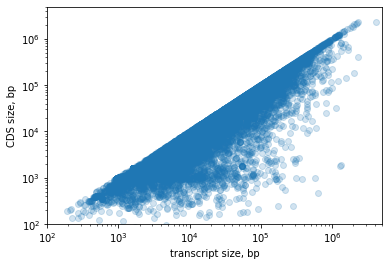

In [41]:
plt.scatter((ddd.loc[:,2] - ddd.loc[:,1]).values,(ddd.loc[:,11] - ddd.loc[:,10]).values,alpha=0.2)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim((100,5e6))
ax.set_ylim((100,5e6))
ax.set_xlabel("transcript size, bp")
ax.set_ylabel("CDS size, bp")



Text(0, 0.5, 'TSS--->CDS distance, bp')

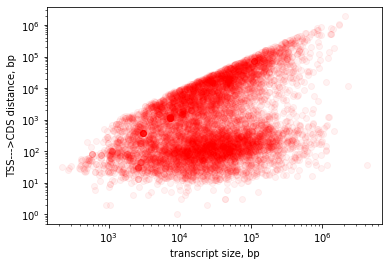

In [81]:
# 1---->2 # transcript coords
# 10-->11 # CDS coords
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
y = (ddd.loc[:,10] - ddd.loc[:,1])[(ddd.iloc[:,5]=="+")&(ddd.iloc[:,8]=="protein-coding")].values
x = (ddd.loc[:,2] - ddd.loc[:,1])[(ddd.iloc[:,5]=="+")&(ddd.iloc[:,8]=="protein-coding")].values

plt.loglog(x,y,'ro',alpha=0.05)
ax = plt.gca()#.set_xscale("log")
# plt.gca().set_title("distribution of CDS")
ax.set_xlabel("transcript size, bp")
ax.set_ylabel("TSS--->CDS distance, bp")


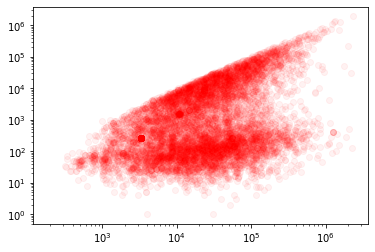

In [79]:
# 2---->1
# 11-->10
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
y = (ddd.loc[:,2] - ddd.loc[:,11])[(ddd.iloc[:,5]=="-")&(ddd.iloc[:,8]=="protein-coding")].values
x = (ddd.loc[:,2] - ddd.loc[:,1])[(ddd.iloc[:,5]=="-")&(ddd.iloc[:,8]=="protein-coding")].values

plt.loglog(x,y,'ro',alpha=0.05)
# plt.gca().set_xscale("log")
# plt.gca().set_title("distribution of CDS")

<AxesSubplot:>

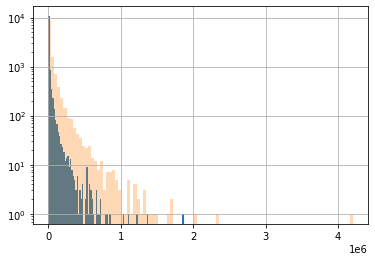

In [56]:
# bins = np.linspace(0,1e6,200)
# bins = np.geomspace(100,1e6,200)
(ddd.loc[:,10] - ddd.loc[:,1])[ddd.iloc[:,5]=="+"].hist(bins=100,log=True)
(ddd.loc[:,2] - ddd.loc[:,1])[ddd.iloc[:,5]=="+"].hist(bins=100,log=True,alpha=0.3)

# plt.gca().set_xscale("log")
# plt.gca().set_title("distribution of CDS")

Text(0.5, 1.0, 'distribution of CDS')

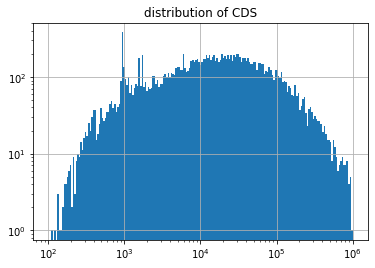

In [31]:
# bins = np.linspace(0,1e6,200)
bins = np.geomspace(100,1e6,200)
(ddd.loc[:,11] - ddd.loc[:,10]).hist(bins=bins,log=True)
plt.gca().set_xscale("log")
plt.gca().set_title("distribution of CDS")

In [43]:
aaa = ddd[ddd[8] == "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("protein-coding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("protein-coding-genes-.bed",index=False,header=None,sep="\t")

In [44]:
# let's look at other types of transcripts separately !
aaa = ddd[ddd[8] != "protein-coding"].copy()
aaa[4] = 1
paaa = (aaa[5] == "+")
maaa = (aaa[5] == "-")
aaa[paaa].iloc[:,:6].to_csv("noncoding-genes+.bed",index=False,header=None,sep="\t")
aaa[maaa].iloc[:,:6].to_csv("noncoding-genes-.bed",index=False,header=None,sep="\t")

In [45]:
! wc -l protein-coding-genes+.bed
! wc -l protein-coding-genes-.bed
! wc -l noncoding-genes+.bed
! wc -l noncoding-genes-.bed

8590 protein-coding-genes+.bed
8295 protein-coding-genes-.bed
4045 noncoding-genes+.bed
3955 noncoding-genes-.bed


In [120]:
! bedToBigBed -tab -type=bed6 protein-coding-genes+.bed hg19.sizes pcgene_plus.bb
! bedToBigBed -tab -type=bed6 protein-coding-genes-.bed hg19.sizes pcgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8590 records, 6 fields): 16 millis
pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (8295 records, 6 fields): 16 millis


In [15]:
! bedToBigBed -tab -type=bed6 noncoding-genes+.bed hg19.sizes ncgene_plus.bb
! bedToBigBed -tab -type=bed6 noncoding-genes-.bed hg19.sizes ncgene_minus.bb

pass1 - making usageList (24 chroms): 2 millis
pass2 - checking and writing primary data (4045 records, 6 fields): 12 millis
pass1 - making usageList (25 chroms): 1 millis
pass2 - checking and writing primary data (3955 records, 6 fields): 7 millis


### let's merge TSS with G4 peaks to defin all G4/transcription related locations ...

In [49]:
# bf is short for bioframe here ...
df = bioframe.read_table(
    "G4-Mao-sort",
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df.reset_index(drop=True)
print(f"G4 ChipSeq peaks {len(df)}")
# bf is short for bioframe here ...
_df = pd.concat([TSS.rename({0:"chrom",1:"start",2:"end"},axis=1),df]).sort_values(["chrom","start"]).reset_index(drop=True)
bioframe.merge(_df, min_dist=1000)[["chrom","start","end"]].to_csv("union_G4_TSS.bed",header=None,index=False,sep="\t")
print(f"and the union list is {len(_df)} bs {len(df)+len(TSS)}")


G4 ChipSeq peaks 8955
and the union list is 32826 bs 32826


In [91]:
tss = TSS.rename({0:"chrom",1:"start",2:"end"},axis=1).copy()
# iii = np.arange(len(tss))
# np.random.shuffle(iii)
# tss.index = iii
# tss


In [38]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [65]:
! cat geneAnnotationsExonUnions.bed |cut -f1-4 > justGenes.bed

In [90]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb! head -3000 geneAnnotationsExonUnions.bed|tail

chr10	70173820	70231878	DNA2	55	-	union_1763	1763	protein-coding	DNA replication helicase/nuclease 2	70174795	70231621	70173820,70176463,70178790,70179559,70181981,70182271,70182453,70190192,70190192,70191613,70191962,70192150,70196767,70202673,70204677,70206052,70209784,70218860,70225423,70227879,70229737,70231547,70231547,70231810	70174862,70176612,70178970,70179649,70182186,70182361,70182647,70190297,70190412,70191728,70192072,70192267,70196998,70202868,70204840,70206170,70210004,70218992,70225569,70228063,70229920,70231642,70231730,70231878
chr10	70320093	70454242	TET1	164	+	union_80312	80312	protein-coding	tet methylcytosine dioxygenase 1	70332095	70451571	70320093,70331973,70360737,70404454,70411602,70412257,70426801,70432651,70441155,70442592,70446112,70450564	70320499,70334009,70360791,70406762,70411693,70412351,70427013,70432802,70441245,70442730,70446464,70454242
chr10	70480995	70552134	CCAR1	94	+	union_55749	55749	protein-coding	cell division cycle and apoptosis regulator 1	

In [66]:
! head justGenes.bed

chr1	11868	14362	DDX11L17
chr1	11873	14409	DDX11L1
chr1	14361	29370	WASH7P
chr1	17368	17436	MIR6859-4
chr1	17368	17436	MIR6859-1
chr1	17368	17436	MIR6859-3
chr1	17368	17436	MIR6859-2
chr1	30365	30503	MIR1302-11
chr1	30365	30503	MIR1302-10
chr1	30365	30503	MIR1302-9


In [67]:
! bedToBigBed -tab -type=bed4 justGenes.bed hg19.sizes hg19_annot.bb

pass1 - making usageList (25 chroms): 7 millis
pass2 - checking and writing primary data (24885 records, 4 fields): 40 millis


In [68]:
ls -lah hg19*

-rw-rw-r-- 1 sergpolly sergpolly 418K Mar 25 18:32 hg19_annot.bb
-rwxrwxr-x 1 sergpolly sergpolly  376 Mar 25 17:35 hg19.reduced.chrom.sizes*
-rw-rw-r-- 1 sergpolly sergpolly 2.0K Mar 25 17:54 hg19.sizes


In [42]:
#wget http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed

In [70]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 299451,
 'zoomLevels': 6,
 'chromCount': 25,
 'summary': {'basesCovered': 1157192927,
  'sum': 1246306033.0,
  'mean': 1.077007994017924,
  'min': 1.0,
  'max': 21.0,
  'std': 0.4987228052953744}}

In [115]:
bbi.fetch_intervals("hg19_annot.bb","chr1",40_000_000,40_200_000,iterator=False)

,chrom,start,end,name,score,strand
0,chr1,40026489,40042462,PABPC4,1,-
1,chr1,40089106,40105315,HEYL,1,-
2,chr1,40124792,40137710,NT5C1A,1,-
3,chr1,40144319,40157157,HPCAL4,1,-


In [114]:
bbi.fetch_intervals?

In [113]:
bbi.info("hg19_annot.bb")

{'version': 4,
 'isCompressed': True,
 'isSwapped': 0,
 'primaryDataSize': 212267,
 'zoomLevels': 5,
 'chromCount': 24,
 'summary': {'basesCovered': 1009255353,
  'sum': 1062351689.0,
  'mean': 1.052609417272023,
  'min': 1.0,
  'max': 21.0,
  'std': 0.45984559662229113}}

In [111]:
# bbi.fetch?
xxx = bbi.fetch(
    "hg19_annot.bb",
    "chr1",
    40_000_000,
    40_200_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)


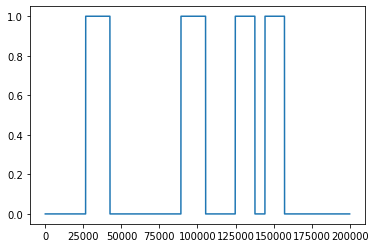

In [112]:
plt.plot(xxx)

In [77]:
!pwd

/home/sergpolly/Desktop/ALV-repo


In [4]:
# ! tail S44_NT_S442_IAA.output_events_all_select_hg19.txt

In [8]:
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt ./
! scp ghpcc:/nl/umw_job_dekker/users/av90w/projects/for-paper/for-higlass/S44_NT_S442_IAA.output_events_all_select_hg19.txt ./

AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all 100%   79KB 825.7KB/s   00:00    
S44_NT_S442_IAA.output_events_all_select_hg19 100%   48KB 533.7KB/s   00:00    


In [ ]:
! bedSort {DATADIR}/{ASSEMBLY}/geneAnnotationsExonUnions.bed geneAnnotationsExonUnions.bed

In [15]:
! bedSort AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt SpliceDDX55aux.bed
! bedSort S44_NT_S442_IAA.output_events_all_select_hg19.txt SpliceCTCFaux.bed

In [10]:
! bedToBigBed -tab -type=bed3 SpliceDDX55aux.bed hg19.sizes SpliceDDX55aux.bb
! bedToBigBed -tab -type=bed3 SpliceCTCFaux.bed hg19.sizes SpliceCTCFaux.bb

pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (3410 records, 3 fields): 4 millis
pass1 - making usageList (23 chroms): 1 millis
pass2 - checking and writing primary data (2079 records, 3 fields): 3 millis


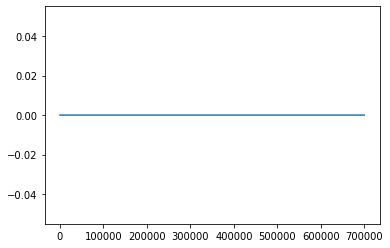

In [17]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceDDX55aux.bb",
    "chr15",
    40_000_000,
    40_700_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)

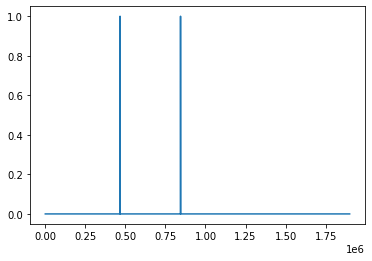

In [27]:
# bbi.fetch?
xxx = bbi.fetch(
    "SpliceCTCFaux.bb",
    "chr1",
    39_000_000,
    40_900_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)
plt.plot(xxx)